In [1]:
import os
import sys
sys.path.append('../utils')
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
import albumentations
from visdom import Visdom
from tqdm import tqdm

import segmentation_models_pytorch as smp
from datasets import ACDCDataset
from models import ENet
from training import dice_loss, tversky_loss, ce_loss

EXP_NAME = 'enet-256'
LOG_FILE = EXP_NAME + '.log'
VIS_FILE = EXP_NAME + '.vislog'

In [2]:
augmentation = albumentations.Compose([
    albumentations.OneOf([
        albumentations.GridDistortion(p=1.),
        albumentations.ElasticTransform(p=1.),
        albumentations.OpticalDistortion(p=1.),
        albumentations.ShiftScaleRotate(p=1.),
    ], p=.7),
    albumentations.RandomBrightnessContrast(p=.7),
    albumentations.RandomGamma(p=.7),
    albumentations.RandomRotate90(p=.7),
    albumentations.Rotate(p=1.),
    albumentations.VerticalFlip(p=.7),
    albumentations.HorizontalFlip(p=.7),
    albumentations.Transpose(p=.7),
    albumentations.CLAHE(p=1.),
    albumentations.Resize(256, 256),
])

dataset = ACDCDataset('../data/acdc/training', None, augmentation, preload=True)
train_dataset, val_dataset = dataset.split_train_val(train_size=0.7)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [3]:
len(train_dataset), len(val_dataset)

(1328, 574)

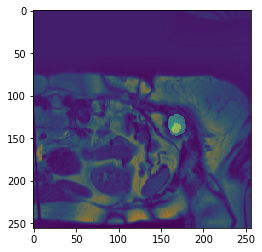

In [4]:
c, img, mask = dataset[79]
plt.imshow(img.numpy()[0])
plt.imshow(mask.numpy()[0], alpha=0.5)
plt.show()

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
model = ENet(n_classes=3).to(device)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)
criterion = lambda p,t : dice_loss(t, p) * .75 + ce_loss(t.squeeze(1), p, weights=None) * .25
metric = lambda p,t : dice_loss(t, p) * .75 + ce_loss(t.squeeze(1), p, weights=None) * .25

In [8]:
if not os.path.exists(os.path.join('chckpoints', EXP_NAME)):
    os.makedirs(os.path.join('chckpoints', EXP_NAME))

In [9]:
vis = Visdom(log_to_filename=VIS_FILE, offline=True)
train_losses = np.ones(100)
val_losses = np.ones(100)
for epoch in range(100):
    train_loss = 0.
    val_loss = 0.
    model.train()
    for _, images, targets in tqdm(train_generator, total=len(train_generator)):
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # backpropagate
        pred = model(images)
        loss = criterion(pred, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(train_generator)
    torch.cuda.empty_cache()
    model.eval()
    for _, images, targets in tqdm(val_generator, total=len(val_generator)):
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            pred = model(images)
        loss = metric(pred, targets)
        val_loss += loss.item() / len(val_generator)
    if epoch % 10 == 0: torch.save(model.state_dict(), os.path.join('chckpoints', EXP_NAME, 'checkpoints_%d.pth' % epoch))
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    vis.line(X=[epoch], Y=[train_loss], win='loss curves', name='train', update='append')
    vis.line(X=[epoch], Y=[val_loss], win='loss curves', name='val', update='append')
    vis.line(X=[epoch], Y=[optimizer.param_groups[0]['lr']], win='loss curves', name='lr', update='append')
    print('epoch: %d train loss: %.3f val loss: %.3f time: %s' % (epoch, train_loss, val_loss, str(datetime.datetime.now())))
    with open(LOG_FILE, 'a') as _f:
        print('epoch: %d train loss: %.3f val loss: %.3f time: %s' % (epoch, train_loss, val_loss, str(datetime.datetime.now())), file=_f)
    if optimizer.param_groups[0]['lr'] < 2e-8:
        train_losses = train_losses[:epoch+1]
        val_losses = val_losses[:epoch+1]
        break

  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 0 train loss: 0.910 val loss: 0.860 time: 2020-06-01 20:36:13.204698


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 1 train loss: 0.827 val loss: 0.781 time: 2020-06-01 20:37:08.154231


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 2 train loss: 0.762 val loss: 0.718 time: 2020-06-01 20:38:00.949166


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 3 train loss: 0.708 val loss: 0.678 time: 2020-06-01 20:38:58.067584


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 4 train loss: 0.661 val loss: 0.635 time: 2020-06-01 20:39:53.308218


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 5 train loss: 0.622 val loss: 0.599 time: 2020-06-01 20:40:49.774009


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 6 train loss: 0.586 val loss: 0.567 time: 2020-06-01 20:41:45.532093


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 7 train loss: 0.550 val loss: 0.544 time: 2020-06-01 20:42:41.002240


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 8 train loss: 0.514 val loss: 0.487 time: 2020-06-01 20:43:37.222942


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 9 train loss: 0.475 val loss: 0.448 time: 2020-06-01 20:44:32.326510


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 10 train loss: 0.436 val loss: 0.401 time: 2020-06-01 20:45:28.862634


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 11 train loss: 0.401 val loss: 0.364 time: 2020-06-01 20:46:27.071779


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 12 train loss: 0.366 val loss: 0.345 time: 2020-06-01 20:47:22.341509


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 13 train loss: 0.340 val loss: 0.318 time: 2020-06-01 20:48:16.461788


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 14 train loss: 0.325 val loss: 0.305 time: 2020-06-01 20:49:11.816269


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 15 train loss: 0.307 val loss: 0.278 time: 2020-06-01 20:50:06.690743


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 16 train loss: 0.293 val loss: 0.259 time: 2020-06-01 20:51:04.981071


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 17 train loss: 0.261 val loss: 0.232 time: 2020-06-01 20:52:00.989807


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 18 train loss: 0.245 val loss: 0.213 time: 2020-06-01 20:52:57.768887


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 19 train loss: 0.226 val loss: 0.197 time: 2020-06-01 20:53:51.111016


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 20 train loss: 0.213 val loss: 0.190 time: 2020-06-01 20:54:49.543393


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 21 train loss: 0.199 val loss: 0.207 time: 2020-06-01 20:55:47.497531


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 22 train loss: 0.192 val loss: 0.172 time: 2020-06-01 20:56:44.635639


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 23 train loss: 0.191 val loss: 0.169 time: 2020-06-01 20:57:40.704935


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 24 train loss: 0.187 val loss: 0.175 time: 2020-06-01 20:58:35.722453


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 25 train loss: 0.176 val loss: 0.156 time: 2020-06-01 20:59:34.970711


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 26 train loss: 0.168 val loss: 0.153 time: 2020-06-01 21:00:27.118695


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 27 train loss: 0.170 val loss: 0.147 time: 2020-06-01 21:01:19.732989


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 28 train loss: 0.168 val loss: 0.149 time: 2020-06-01 21:02:14.998358


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 29 train loss: 0.169 val loss: 0.151 time: 2020-06-01 21:03:09.799440


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 30 train loss: 0.172 val loss: 0.142 time: 2020-06-01 21:04:05.407492


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 31 train loss: 0.163 val loss: 0.134 time: 2020-06-01 21:04:58.380601


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 32 train loss: 0.153 val loss: 0.146 time: 2020-06-01 21:05:52.309951


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 33 train loss: 0.153 val loss: 0.134 time: 2020-06-01 21:06:46.168062


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 34 train loss: 0.140 val loss: 0.127 time: 2020-06-01 21:07:37.913322


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 35 train loss: 0.147 val loss: 0.129 time: 2020-06-01 21:08:31.748435


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 36 train loss: 0.146 val loss: 0.129 time: 2020-06-01 21:09:26.834119


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 37 train loss: 0.142 val loss: 0.126 time: 2020-06-01 21:10:21.016651


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 38 train loss: 0.141 val loss: 0.129 time: 2020-06-01 21:11:14.184282


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 39 train loss: 0.137 val loss: 0.129 time: 2020-06-01 21:12:07.979146


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 40 train loss: 0.138 val loss: 0.122 time: 2020-06-01 21:12:57.954393


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 41 train loss: 0.138 val loss: 0.125 time: 2020-06-01 21:13:52.408776


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 42 train loss: 0.139 val loss: 0.126 time: 2020-06-01 21:14:44.209247


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 44 train loss: 0.141 val loss: 0.125 time: 2020-06-01 21:16:31.557687


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 45 train loss: 0.139 val loss: 0.119 time: 2020-06-01 21:17:24.484439


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 46 train loss: 0.136 val loss: 0.117 time: 2020-06-01 21:18:17.349681


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 47 train loss: 0.135 val loss: 0.126 time: 2020-06-01 21:19:10.380770


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 48 train loss: 0.129 val loss: 0.115 time: 2020-06-01 21:20:02.657127


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 49 train loss: 0.131 val loss: 0.116 time: 2020-06-01 21:20:55.629767


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 50 train loss: 0.132 val loss: 0.123 time: 2020-06-01 21:21:47.442377


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 51 train loss: 0.128 val loss: 0.112 time: 2020-06-01 21:22:41.810497


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 52 train loss: 0.124 val loss: 0.121 time: 2020-06-01 21:23:37.295718


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 53 train loss: 0.134 val loss: 0.121 time: 2020-06-01 21:24:33.046696


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 54 train loss: 0.133 val loss: 0.107 time: 2020-06-01 21:25:24.711099


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 55 train loss: 0.123 val loss: 0.109 time: 2020-06-01 21:26:18.455933


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 56 train loss: 0.125 val loss: 0.111 time: 2020-06-01 21:27:12.104216


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 58 train loss: 0.122 val loss: 0.117 time: 2020-06-01 21:28:57.783031


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 59 train loss: 0.127 val loss: 0.117 time: 2020-06-01 21:29:51.788916


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 60 train loss: 0.129 val loss: 0.109 time: 2020-06-01 21:30:43.964290


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 61 train loss: 0.124 val loss: 0.116 time: 2020-06-01 21:31:36.341255


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 62 train loss: 0.124 val loss: 0.109 time: 2020-06-01 21:32:28.924510


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 63 train loss: 0.125 val loss: 0.117 time: 2020-06-01 21:33:21.121199


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 64 train loss: 0.124 val loss: 0.112 time: 2020-06-01 21:34:15.347388


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 65 train loss: 0.124 val loss: 0.104 time: 2020-06-01 21:35:08.548056


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 93 train loss: 0.115 val loss: 0.107 time: 2020-06-01 22:00:12.464110


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 94 train loss: 0.113 val loss: 0.116 time: 2020-06-01 22:01:05.805344


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 95 train loss: 0.120 val loss: 0.105 time: 2020-06-01 22:01:59.863193


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 96 train loss: 0.112 val loss: 0.105 time: 2020-06-01 22:02:56.889148


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 97 train loss: 0.115 val loss: 0.103 time: 2020-06-01 22:03:52.774274


  0%|          | 0/42 [00:00<?, ?it/s]

epoch: 98 train loss: 0.113 val loss: 0.105 time: 2020-06-01 22:04:47.742338


100%|██████████| 18/18 [00:13<00:00,  1.37it/s]

epoch: 99 train loss: 0.112 val loss: 0.104 time: 2020-06-01 22:05:41.226101


In [22]:
model.load_state_dict(torch.load('chckpoints/enet-256/checkpoints_90.pth'))
# model = torch.load('unet-densenet161.pth').to(device)

<All keys matched successfully>

In [8]:
torch.cuda.empty_cache()

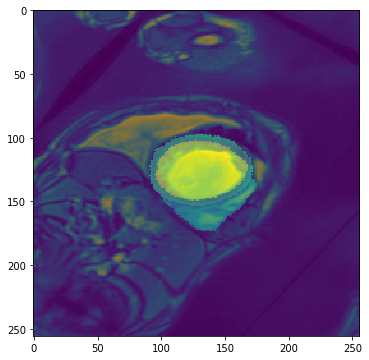

In [18]:
c, img, mask = val_dataset[24]

plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(mask.numpy()[0], alpha=0.5)
plt.show()

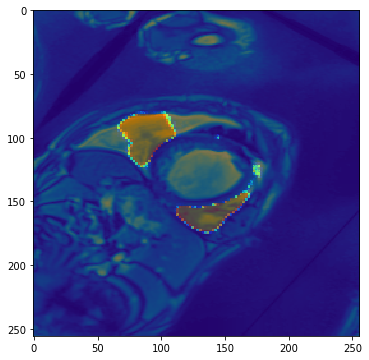

In [23]:
model.eval()
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0]
probas = torch.nn.functional.softmax(pred, dim=0)

plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(probas.cpu().numpy()[1], alpha=0.5, cmap=plt.cm.jet)
plt.show()

In [24]:
torch.save(model, 'enet-256.pth')